In [3]:
import matplotlib.pyplot as plt
import numpy as np
import skimage
import napari
import pyclesperanto as cle

from mt.ct_utils import contact_area

cle.select_device("RTX")

(OpenCL) NVIDIA GeForce RTX 3060 Laptop GPU (OpenCL 3.0 CUDA)
	Vendor:                      NVIDIA Corporation
	Driver Version:              516.95
	Device Type:                 GPU
	Compute Units:               30
	Global Memory Size:          6143 MB
	Maximum Object Size:         1535 MB
	Max Clock Frequency:         1425 MHz
	Image Support:               Yes

In [2]:
cle.list_available_backends()
# cle.select_backend("cuda")

['opencl']

In [2]:
particles = np.load("../../04_uCT/AD67/_particle_mask.npy")
particles = np.transpose(particles, (1, 0, 2))
tesselation = np.load("../../04_uCT/AD67/_tesselation.npy")
tesselation = np.transpose(tesselation, (1, 0, 2))
mask = np.load("../../04_uCT/AD67/_mask.npy")
mask = np.transpose(mask, (1, 0, 2))

print(particles.shape)
tess_slice = tesselation[63]
part_slice = particles[63]
mask_slice = mask[63]

(126, 1781, 2231)


In [3]:
viewer = napari.Viewer()
viewer.add_labels(tess_slice)
viewer.add_labels(part_slice)
viewer.add_labels(mask_slice)

<Labels layer 'mask_slice' at 0x22872187e10>

In [20]:
def divide_into_grid(image, 
                     cells: tuple[int, int] = (3, 3),
                     exclude_edges: bool = True):
    h, w = image.shape
    cell_h = h // cells[0]
    cell_w = w // cells[1]
    regions = []
    for i in range(cells[0]):
        for j in range(cells[1]):
            region = image[i*cell_h:(i+1)*cell_h, j*cell_w:(j+1)*cell_w]
            if exclude_edges:
                region = cle.pull(cle.exclude_labels_on_edges(region))
            regions.append(region)
    return regions

def region_cell_areas(regions):
    areas = []
    for region in regions:
        cell_areas, _ = skimage.exposure.histogram(region)
        cell_areas = np.sort(cell_areas[cell_areas > 0])[:-1]
        areas.append(cell_areas)
    return areas

def polymer_contact(regions):
    contact_pct = []
    for region in regions:
        region = region[..., np.newaxis]
        air_Al = contact_area(region, 1, 3)
        poly_Al = contact_area(region, 2, 3)
        contact_pct.append(poly_Al/(air_Al + poly_Al))
    contact_pct = np.array(contact_pct)
    return contact_pct

def get_areas_and_contact(tess_slice, mask_slice, regions=(3, 3)):
    # get means of voronoi cell areas for regions
    cells = divide_into_grid(tess_slice, regions)
    print("Region size: ", cells[0].shape)
    areas = region_cell_areas(cells)
    mean_areas = np.array([np.mean(area)*2.5**2 for area in areas])
    mean_areas = mean_areas.reshape(*regions)
    
    # get polymer contact percentage for regions
    cells = divide_into_grid(mask_slice, exclude_edges=False, cells=regions)
    contact_percent = polymer_contact(cells).reshape(*regions)
    return mean_areas, contact_percent

def visualise_region_properties(tess_slice, 
                                mask_slice, 
                                cells=(3, 3)):
    mean_areas, contact_percent = get_areas_and_contact(tess_slice, mask_slice, cells)
    
    fig, axs = plt.subplots(1, 2, figsize=(15, 7))
    im = axs[0].imshow(mean_areas, cmap="inferno")
    axs[0].set_title("Mean area of cells in regions im um^2")
    fig.colorbar(im, ax=axs[0])
    im = axs[1].imshow(contact_percent, cmap="inferno")
    axs[1].set_title("Polymer contact percentage")
    fig.colorbar(im, ax=axs[1])
    plt.show()
    return mean_areas, contact_percent
    


Region size:  (540, 743)


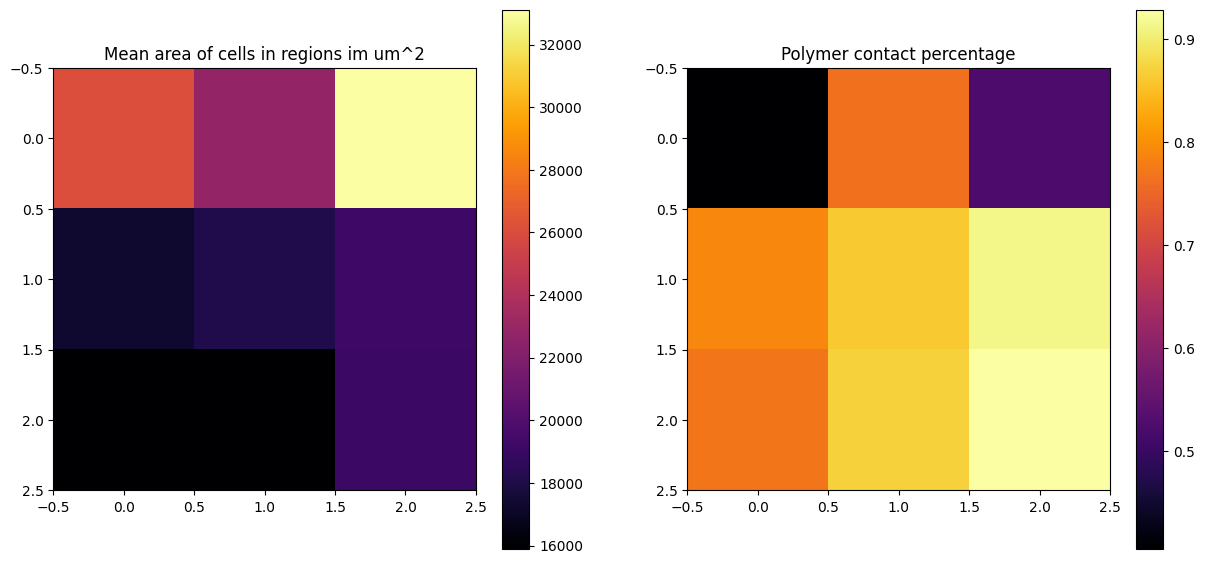

Region size:  (270, 371)


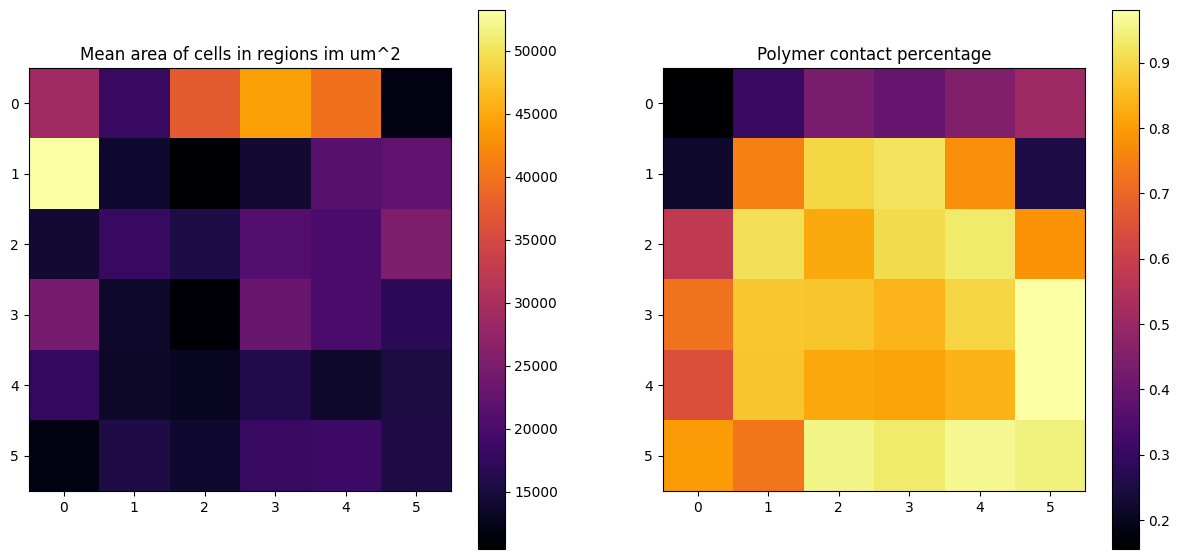

Region size:  (180, 247)


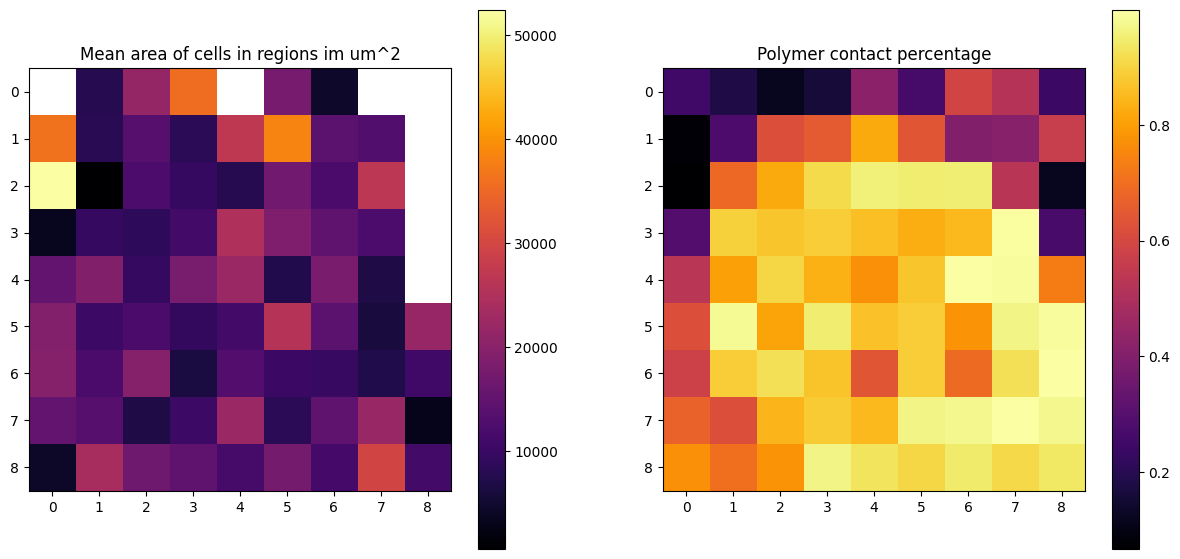

In [21]:
area_list = []
contact_list = []
for ii in [3, 6, 9]:
    areas, contact = visualise_region_properties(tess_slice, mask_slice, (ii, ii))
    area_list.append(areas)
    contact_list.append(contact)

Text(0, 0.5, 'Polymer contact percentage')

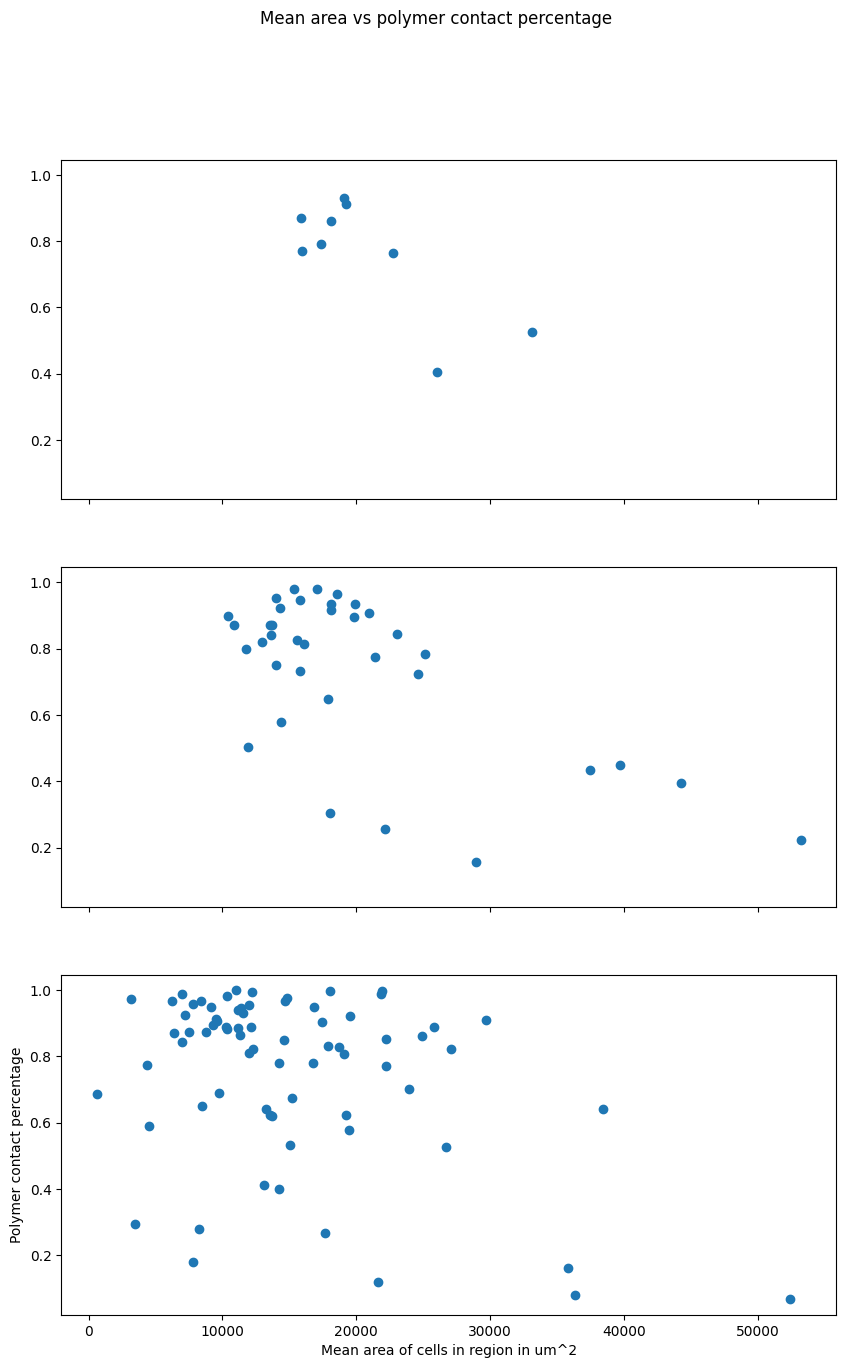

In [22]:
# areas, contact = np.sort(areas.flatten()), np.sort(contact.flatten())
fig, axs = plt.subplots(3, figsize=(10, 15), sharex=True, sharey=True)
for ii in range(3):
    areas, contact = area_list[ii], contact_list[ii]
    axs[ii].plot(areas.ravel(), contact.ravel(), "o")
plt.suptitle("Mean area vs polymer contact percentage")
plt.xlabel("Mean area of cells in region in um^2")
plt.ylabel("Polymer contact percentage")